# Разработка стратегии взаимодействия с клиентами сети фитнес-центров 

***Цель проекта*** - разработать систему выявления и работы с оттоком клиентов с помощью инструментов машинного обучения

***Описание проекта***

Сеть фитнес-центров разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных.

Можно считать, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал.
Чтобы бороться с оттоком, было переведено в электронный вид множество клиентских анкет. Необходимо провести анализ:

- научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
- сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
- проанализировать основные признаки, наиболее сильно влияющие на отток;
- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами: выделить целевые группы клиентов, предложить меры по снижению оттока, определить другие особенности взаимодействия с клиентами.

***Ход проекта***

Необходимо произвести обзор данных, предобработку, обучить модель и составить прогноз оттока, произвести кластеризацию клиентов, сформулировать выводы и дать рекомендации. 

## Обзор данных

Импортируем необходимые для анализа библиотеки:

In [1]:
# импортируем необходимые библиотеки для работы с данными

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from termcolor import colored
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage 
import itertools

import warnings
warnings.filterwarnings('ignore')

Добавляем функцию для обзора данных:

In [2]:
# функция для обзора данных в таблице
def view(data, name):
    print(colored('Обзор данных таблицы', 'blue'), name)
    print()
    print('Первые 5 строк данных')
    display(data.head()) # Выводим первые 5 строк
    print()
    print('Информация по таблице')
    display(data.info()) # Выводим инфо по датасету
    print()
    print('Пропуски')
    display(data.isna().sum())
    print()
    print('Количество явных дубликатов:', data.duplicated().sum())
    print()

Сохраняем датасет в переменную и с помощью функции производим обзор данных датасета:

In [3]:
# сохраняем данные в переменную
data = pd.read_csv('/datasets/gym_churn.csv')

# открываем его с помощью функции
view(data, colored('с данными по оттоку', 'blue'))

Обзор данных таблицы с данными по оттоку

Первые 5 строк данных


,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0



Информация по таблице
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total        

None


Пропуски


gender                               0
Near_Location                        0
Partner                              0
Promo_friends                        0
Phone                                0
Contract_period                      0
Group_visits                         0
Age                                  0
Avg_additional_charges_total         0
Month_to_end_contract                0
Lifetime                             0
Avg_class_frequency_total            0
Avg_class_frequency_current_month    0
Churn                                0
dtype: int64


Количество явных дубликатов: 0



Данные клиента за предыдущий до проверки факта оттока месяц:
- 'gender' — пол;
- 'Near_Location' — проживание или работа в районе, где находится фитнес-центр;
- 'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
- 'Promo_friends' — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
- 'Phone' — наличие контактного телефона;
- 'Age' — возраст;
- 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах).


Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
- 'Contract_period' — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
- 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);
- 'Group_visits' — факт посещения групповых занятий;
- 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;
- 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;
- 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
- 'Churn' — факт оттока в текущем месяце.


Так как у нас нет документации, то в бинарных признаках мы предполагаем, что 1 -это ответ "да", 0 - ответ "нет". 
Для факта оттока - это будет выглядеть как 1 "да, отток" или 0 "нет, не отток". 

### Вывод

Дубликатов и пропусков нет. Название столбцов указаны в верхнем регистре, для удобства работы можно привести к нижнему. Необходимо произвести исследовательский анализ данных, чтобы проверить распределения признаков по группам пользователей, которые ушли в отток и тем, кто остались. При необходимости почистить данные и сделать первичные выводы. 

## Исследовательский анализ данных

Для удоства работы приведем все названия столбцов к нижнему регистру:

In [4]:
# приводим названия столбцов к нижнему регистру
data.columns = data.columns.str.lower()
data.columns

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month',
       'churn'],
      dtype='object')

Проверим информацию по средним значениям и стандтному отклонению, чтобы определенить различие параметров:

In [5]:
# выводим обзор таблицы
data.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


Исходя из этих данных мы можем видеть, что в датасете:
- люди по полу распределены равномерно
- большинство из них проживает в районе фитнес-центра
- примерно половина из них является сотрудниками компаний-партнеров клуба
- меньше половины клиентов приходят по программе "приведи друга"
- практически все клиенты указывают номер телефона
- в среднем абонемент берут на 4-5 месяцев, но среднее отклонение от этого значения довольно большое. Максимально абонемент покупают на 12 месяцев
- только половина посетителей ходят на групповые программы
- средний возраст посетителей 29 лет, минимальный 18 лет, максимальный - 41 год
- средняя выручка от других услуг составляет 146. Видим, что минимальное значение 0,14, это значит, что большинство посетителей так или иначе использую дополнительные услуги
- в среднем до конца текущего абонемента у посетителей остается 4 месяцев
- в среднем посетители ходят в клуб в течении 3х месяцев, максимальный срок составляет 31 месяц
- в среднем клуб посещают около 2х раз в неделю
- за последний месяц частота посещений в среднем немного снизилась, но не сильно
- большая часть клиентов в выгрузке - это клиенты не из оттока

Рассмотрим средние данные по разным показателям если сгруппировать клиентов по тем, кто ушел в отток и тем, кто остался:

In [6]:
# группируем данные по столбцу churn, рассмотрим средние значения по каждому из параметров
gr = data.groupby('churn').mean().T
gr

churn,0,1
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
contract_period,5.747193,1.728558
group_visits,0.464103,0.268615
age,29.976523,26.989632
avg_additional_charges_total,158.445715,115.082899
month_to_end_contract,5.283089,1.662582


Видим, что:
- по полу клиенты в оттоке и действующие клиенты равномерно распределены
- в среднем и те, и другие часто проживают в районе, где расположен в клуб. Однако клиенты в оттоке чуть чаще ходят в клуб из других районов, что может влиять на их лояльность
- в среднем действующие клиенты чаще являются сотрудниками компаний-партнеров клуба и приходят по программе "приведи друга"
- видно, что средний период абонемента у клиентов в оттоке сильно меньше - 2 месяца против 6
- клиенты, которые переходят в отток меньше тратят на доп. услуги в среднем, реже ходят на групповые занятия, посещают клуб 1 раз в неделю в среднем, против 2х у действующих клиентов

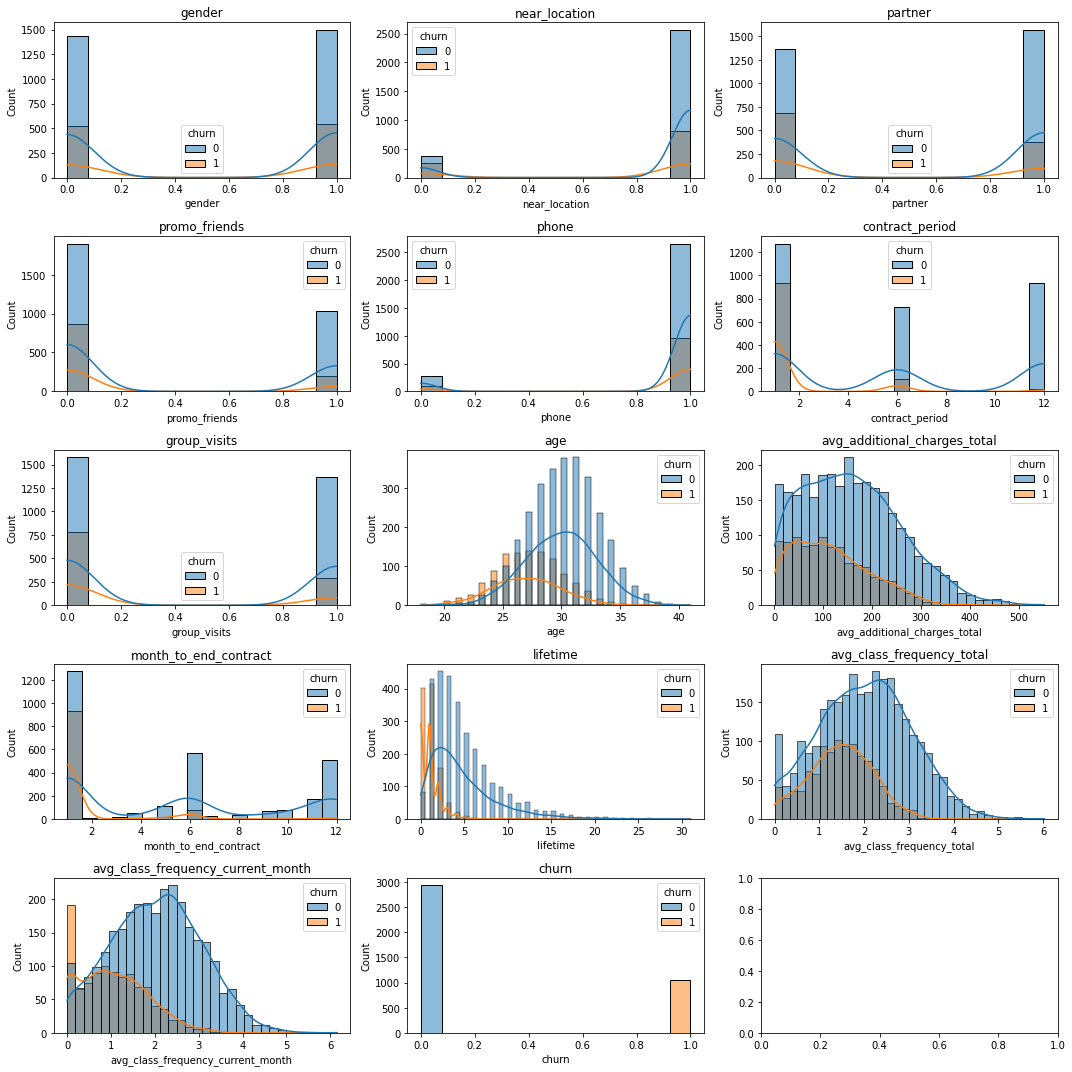

In [7]:
# строим диаграммы
fig, ax = plt.subplots(nrows=5, ncols=3, figsize=(15, 15))
ax = ax.flatten()
    
for i in range(len(data.columns)):
    sns.histplot(data=data, x=data[data.columns[i]], hue='churn', ax=ax[i], kde=True)
    ax[i].set_title(f'{data.columns[i]}')
        
fig.tight_layout()
fig.show()

По графикам мы видим примерно тоже, что и по средним значениям. Еще можно заметить, что клиенты в оттоке:
- младше по возрасту, исходя из диаграммы возрастных показателей
- чаще всего их абонементы короче - срок окончания в течении 1-2 месяцев
- они обычно уходят в течении первых 5 месяцев, те клиенты, которые ходят в клуб дольше обычно остаются его клиентами

Построим тепловую карту корреляции разных признаков клиента:

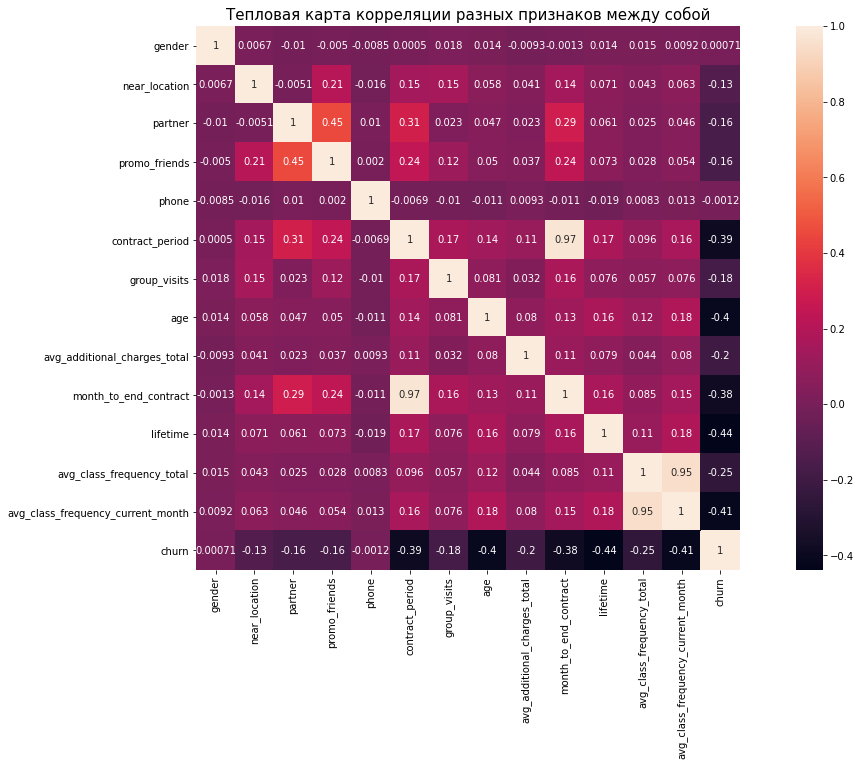

In [8]:
# считаем корреляцию
cm = data.corr()

# рисуем тепловую карту
plt.figure(figsize=(20,10))
sns.heatmap(cm, annot=True, square=True)
plt.title("Тепловая карта корреляции разных признаков между собой", fontsize=15)
plt.show()

Исходя из тепловой карты видно, что две пары признаков имеют коэффициент корреляции больше 0,9, что говорит о весьма сильной зависимости данных признаков друг от друга:
- 'Month_to_end_contract' (срок окончания текущего действующего абонемента) и 'Contract_period' (длительность текущего действующего абонемента) - коэф. корр 0,97
- 'Avg_class_frequency_total' (средняя частота посещения клуба в неделю) и 'Avg_class_frequency_current_month' (средняя частота посещения клуба в неделю за последний месяц) - коэф. корр. 0,95

Из-за высокого показателя корреляции эффект от двух признаков при обучении модели будет такой же, как при использовании одного признака. Если оставим оба признака модель может занулить один из них из-за чего мы не получим корректных данных. 

Чтобы убрать эффект мультиколлинеарности на последующих шагах удалим два из 4х столбцов имеющих высокие показатели корреляции друг с другом:

In [9]:
# удаляем два столбца 'month_to_end_contract', 'avg_class_frequency_current_month'
data = data.drop(columns=['month_to_end_contract', 'avg_class_frequency_current_month'])
data.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,lifetime,avg_class_frequency_total,churn
0,1,1,1,1,0,6,1,29,14.227470,3,0.020398,0
1,0,1,0,0,1,12,1,31,113.202938,7,1.922936,0
2,0,1,1,0,1,1,0,28,129.448479,2,1.859098,0
3,0,1,1,1,1,12,1,33,62.669863,2,3.205633,0
4,1,1,1,1,1,1,0,26,198.362265,3,1.113884,0


### Вывод

Мы сделали предположения относительно признаков тех клиентов, которые переходят в отток, исходя из диаграмм и средних значений. Такие клиенты в среднем чаще:
- живут в другой районе, чем тот, где находится клуб
- пришли самостоятельно (не являются сотрудниками компаний-партнеров и не пришли по акции "приведи друга")
- берут абонементы с небольшим периодом - 1-2 месяца
- не ходят на групповые занятия и не приобретают доп. услуги
- посещают клуб 1 раз в неделю
- в среднем младше по возрасту

Мы обнаружили, что есть две пары признаков, которые очень сильно коррелируют друг с другом. Это может сказаться в дальнейшем при обучении модели. Поэтому мы произвели удаление двух из четырех столбцов с данными признаками. 

## Модель прогнозирования оттока клиентов

Разделим признаки и целевую переменную, обучающую и валидационную выборки:

In [10]:
# разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = data.drop(columns=['churn'])
y = data['churn']

# разделяем модель на обучающую и валидационную выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Обучим модель с помощью логистической регрессии и случайного леса, выведем метрики accuracy, precision и recall для оценки эффективности моделей:

In [11]:
# функция для обучение модели
def make_prediction(m, X_train, y_train, X_test, y_test):
    m = m
    m.fit(X_train, y_train)
    predictions = m.predict(X_test)
    print('Accuracy: {:.2f} Precision: {:.2f} Recall: {:.2f}'.format(accuracy_score(y_test, predictions), 
                                                               precision_score(y_test, predictions),
                                                               recall_score(y_test, predictions)))
# задаем способы, которыми будем обучать модель    
models = [LogisticRegression(solver='liblinear'), RandomForestClassifier()]

# выводим данные через цикл
for i in models:
    print(i)
    make_prediction(i, X_train, y_train, X_test, y_test) 

LogisticRegression(solver='liblinear')
Accuracy: 0.88 Precision: 0.76 Recall: 0.77
RandomForestClassifier()
Accuracy: 0.90 Precision: 0.80 Recall: 0.77


Доля правильных ответов немного больше у случайного леса, при этом он же показывает более высокую точность. Однако полнота у него несколько уступает логистической регрессии. Помним, что мы всегда балансируем между метриками точности и полноты. Улучшая одну, мы можем ухудшать другую. 

Исходя из данных получается, что случайный лес работает лучше, чем логистическая регрессия. 

## Кластеризация клиентов

Произведем кластеризацию клиентов. Для этого стандартизируем данные:

In [12]:
# стандартизируем данные
sc = StandardScaler()
X_sc = sc.fit_transform(X)

Построим дендрограмму для уточнения количества кластеров, на которые будем делить клиентов:

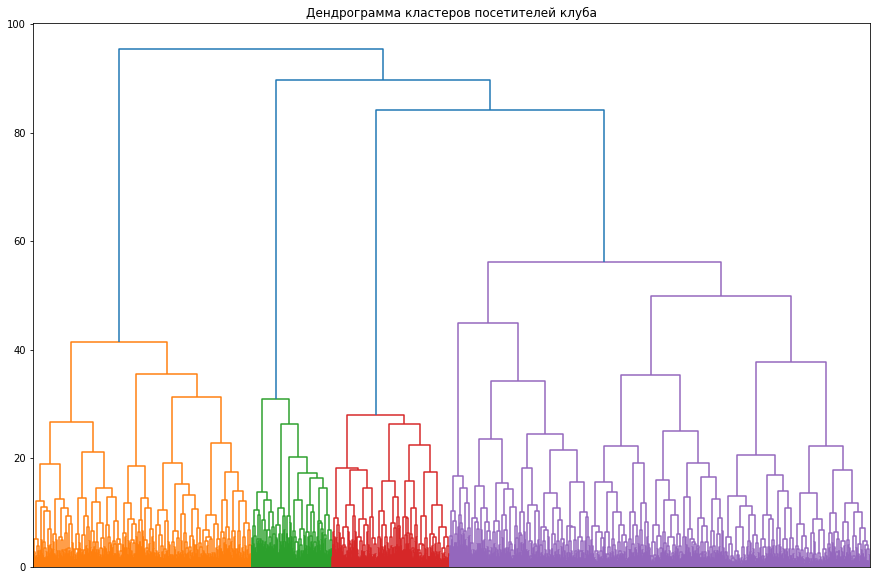

In [13]:
# строим дендрограмму
linked = linkage(X_sc, method = 'ward') 

plt.figure(figsize=(15, 10))  
dendrogram(linked)
plt.title('Дендрограмма кластеров посетителей клуба')
plt.xticks([])
plt.show() 

Дендрограмма показывает, что имеет смысл делить на 4 кластера. Однако последний кластер у нас получается очень большой. Поделим клиентов на 5, чтобы получить большую детализацию признаков:

In [14]:
# задаём модель k_means с числом кластеров 3 и фиксируем значение random_state
km = KMeans(n_clusters=5, random_state=0)
# прогнозируем кластеры для наблюдений (алгоритм присваивает им номера от 0 до 2)
labels = km.fit_predict(X_sc)

# сохраняем метки кластера в поле нашего датасета
data['claster'] = labels

# выводим статистику по средним значениям наших признаков по кластеру
display(data.groupby('claster').mean().T)

claster,0,1,2,3,4
gender,0.499109,0.488571,0.505300,0.544202,0.523316
near_location,0.000000,0.995238,1.000000,1.000000,0.862694
partner,0.488414,0.955238,0.238516,0.250287,0.471503
promo_friends,0.076649,0.892381,0.059187,0.079219,0.305699
phone,1.000000,1.000000,1.000000,1.000000,0.000000
contract_period,3.032086,7.660952,2.819788,4.528129,4.777202
group_visits,0.235294,0.458095,0.000000,1.000000,0.427461
age,28.721925,29.543810,28.770318,29.536165,29.297927
avg_additional_charges_total,137.540009,155.861428,143.383993,148.088897,144.208179
lifetime,3.060606,4.380952,3.343640,3.761194,3.940415


Построим диаграммы распределения признаков в зависимости от целевой переменной:

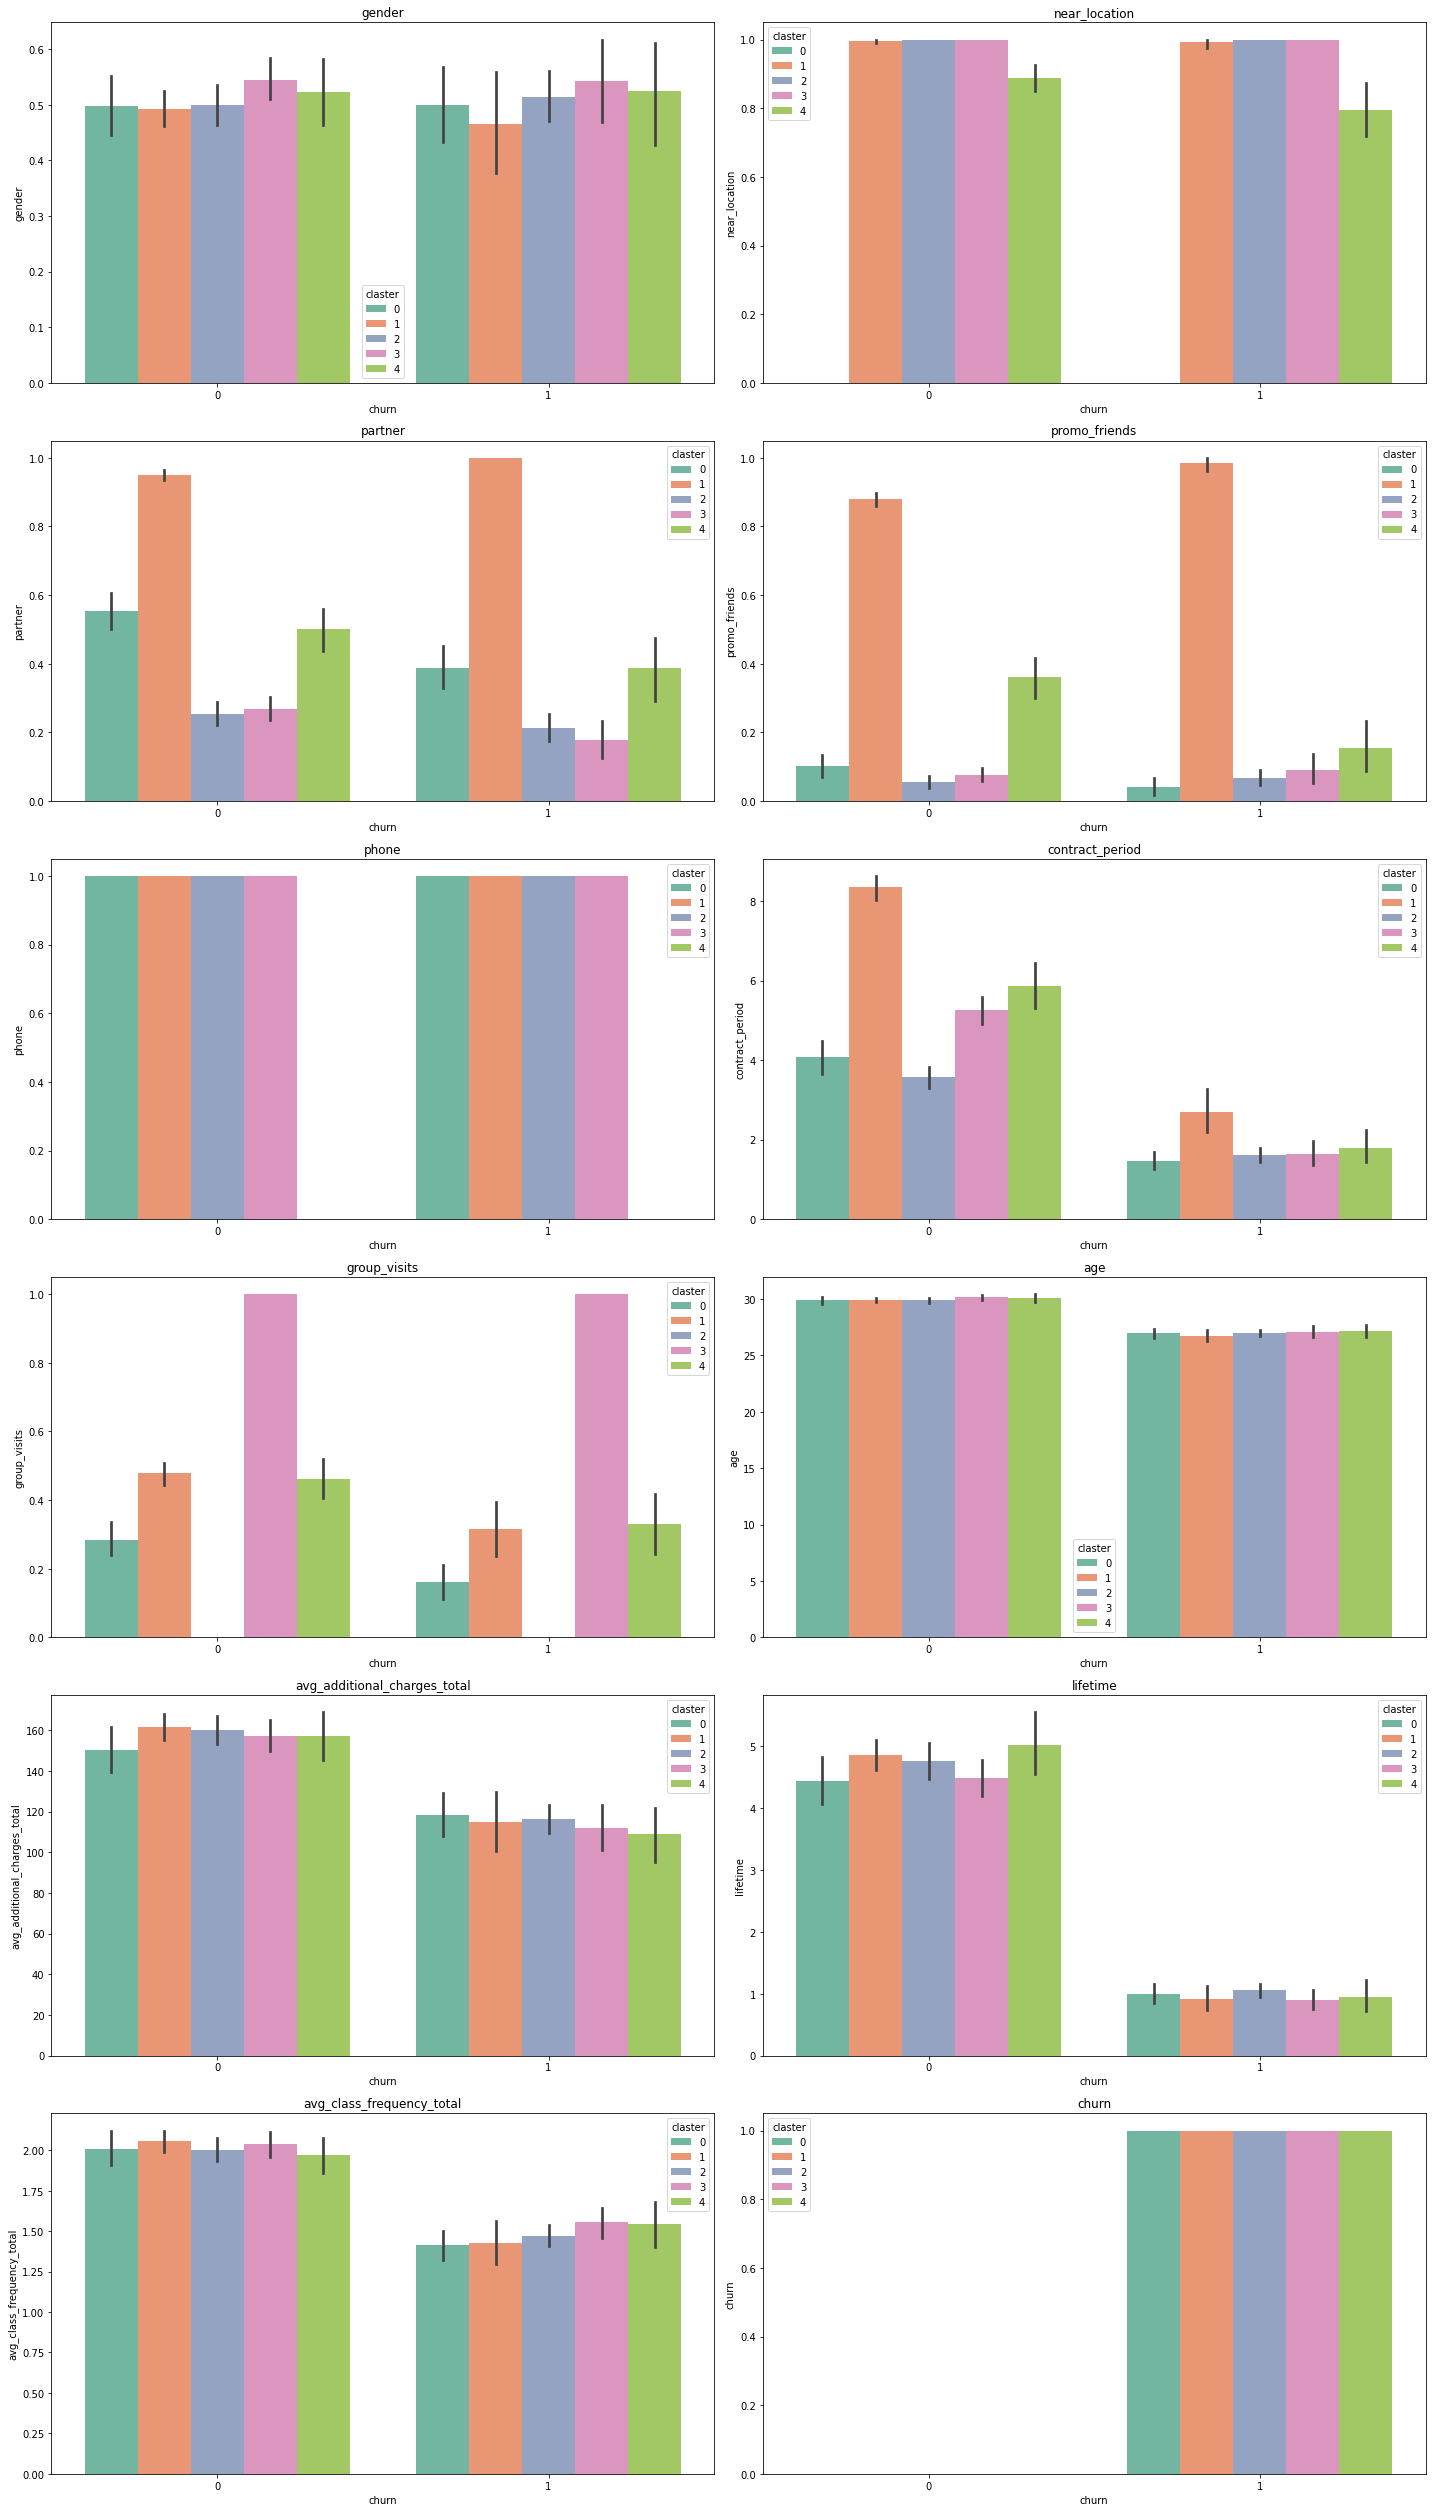

In [15]:
# строим диаграмму
fig, ax = plt.subplots(nrows=6, ncols=2, figsize=(20, 35))
ax = ax.flatten()
    
for i in range(len(data.drop('churn', axis=1).columns)):
    sns.barplot(data=data, x='churn', y=data[data.columns[i]], hue='claster', ax=ax[i], palette="Set2")
    ax[i].set_title(f'{data.columns[i]}')
        
fig.tight_layout()
fig.show()

Определим портрет пользователя, который попадает в каждый из кластеров. 

Кластер 0:
- живет в районе клуба
- в половине случаев является сотрудником компании-партнера
- пришел не по программе "приведи друга"
- занимался в течении 3х месяцев
- практически не ходил на групповые занятия
- тратит меньше 140 на дополнительные услуги клуба
- ходит в среднем 1,7 раз в неделю

Кластер 1:
- живет не в районе клуба
- является сотрудником компании-партнера
- приходит по программе "приведи друга"
- занимается в течении 7 месяцев
- в половине случаев посещают групповые занятия
- ходят в среднем клуб 1,9 раз в неделю

Кластер 2:
- живет не в районе клуба
- не работает в кампании-партнере 
- не пришел по акции "приведи друга"
- занимается в течении 3х месяцев
- совсем не посещает групповые занятия
- ходит в среднем в клуб 1,8 раз в неделю

Кластер 3:
- живет не в районе клуба
- не работает в кампании-партнере
- не пришел по акции "приведи друга"
- занимается в течении 4,5 месяцев 
- постоянно ходит на групповые занятия
- ходит в среднем 1,9 раз в неделю

Кластер 4:
- живет не в районе клуба
- либо работает в кампании-партнере, либо пришел по программе "приведи друга"
- не указал номер телефона
- ходит в клуб в течении 5 месяцев
- в половине случаев посещает групповые занятия
- ходит в клуб в среднем 1,8 раз в неделю

У клиентов в оттоке показатели стандартно ниже, чем у тех, кто до сих пор являются клиентами клуба. 

Посмотрим показатели оттока для каждого отдельного кластера:

Доля оттока по каждому кластеру


claster,0,1,2,3,4
churn,0.399287,0.120952,0.381625,0.200918,0.266839


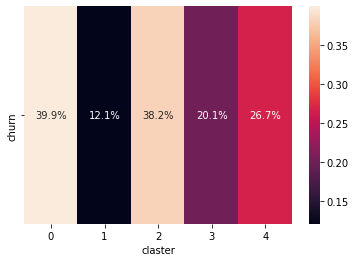

In [16]:
# строим данные оттока по кластеру
print(colored('Доля оттока по каждому кластеру', 'blue'))
churn = data.groupby('claster').agg({'churn':'mean'}).T
display(churn)


sns.heatmap(churn, annot=True,
            fmt='.1%',)
plt.show()

Самые отточные кластеры - 0 и 2. Самый надежный - кластер 1. 
На удивление фактор близости проживания получается влияет не так сильно на отток. Дольше всего посещают клуб те клиенты, которые являются сотрудниками компаний-партнеров, приходят по программе "приведи друга" и ходят на групповые занятия. 

## Вывод 

Мы произвели первичный обзор данных, предобработку, исследовательский анализ данных. На этапе исследовательского анализа данных выявили первичные признаки того, что клиент уйдет в отток - не является сотрудником компании-партнера, пришел не по программе "приведи друга", реже ходит в клуб (1 раз в неделю), меньше платит за дополнительные услуги клуба, в среднем немного младше по возрасту, реже ходит на групповые занятия. 
Также мы определили признаки, которые сильно коррелируют между собой. Это может сильно повлиять на эффективность построения модели, поэтому мы убрали два из 4х признаков.


Мы обучили модель двумя способами:
- логистической регрессией
- случайным лесом

Выявили, что случайный лес показывает более точные результаты на тестовой выборке. Имеет смысл использовать его для построения прогноза оттока клиентов уже на реальных данных. 

Далее нам необходимо было произвести кластеризацию клиентов. С помощью дендрограммы мы определили, что нам необходимо разделить всех клиентов на 4 кластера, однако 4 кластер получился очень большой. Было принято решение разбить его на 2 для более точного выявления признаков отточных клиентов. 

С помощью алгоритма K-Means мы произвели обучение модели. Получили 5 кластеров клиентов. 
В наиболее надежном по оттоку кластере оказались те клиенты, которые являются сотрудниками компаний-партнеров, пришли по программе "приведи друга" и в среднем половина из этих клиентов посещает групповые занятия. 

Самыми ненадежными оказались кластеры 0 и 2. Они отличаются тем, что чаще всего эти клиенты не являются сотрудниками компаний-партнеров, пришли не по программе "приведи друга" и редко посещают групповые занятия. 

Исходя из выявленных особенностей кластеров имеет смысл работать над увеличением числа посетителей, пришедших по программам сотрудничества с компаниями-партнерами и по акции "приведи друга". Вероятно, если клиент посещает клуб вместе с сотрудниками или другом, то он в целом дольше будет посещать занятия. 

Для клиентов, которые пришли не по этим программам, большую роль играет посещение групповых занятий, поэтому имеет смысл мотивировать таких клиентов к их посещению. Мы можем видеть влияние групповых занятий на отток на примере кластера 3, куда попали клиенты, постоянно посещающие их, но при этом пришедшие не по программе "приведи друга" и не являющиеся сотрудниками компаний-партнеров. Их процент оттока сильно ниже, чем у кластеров, где посещение групповых занятий минимально. 